## Imports

In [116]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt

import matplotlib as mpl
mpl.rc('font', family='Georgia')

from tqdm import tqdm

# TODO: Delete
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Reading and preparing data

### Algorithm 1: CMA-ES

In [117]:
ENEMIES = [1,3,4]

DATA_FOLDER_CMAES = os.path.join('data', 'cmaes')
cmaes_data = []

for (i, enemy) in enumerate(ENEMIES):
    cmaes_data.append(np.load(DATA_FOLDER_CMAES + f"/{enemy}/all_fitnesses_static.npy"))

cmaes_data = np.array(cmaes_data)
_, n_runs, n_gens, population_size = cmaes_data.shape
print(cmaes_data.shape)

(3, 10, 100, 100)


In [118]:
# Number of repeated game runs with optimal weights
N_REPEATS = 5

cmaes_gains = np.zeros((len(ENEMIES), N_REPEATS * n_runs))

for (i, enemy) in enumerate(ENEMIES):
    cmaes_gains[i] = np.load(os.path.join(DATA_FOLDER_CMAES, f'{enemy}', 'gains.npy'))

#### Decision data

In [119]:
# 3rd dimension: Mean & STD
# 4th dimension: Left, Right, Jump, Shoot, Release
cmaes_decisions = np.zeros((len(ENEMIES), n_runs, n_gens, 2, 7))

for (i, enemy) in enumerate(ENEMIES):
    cmaes_decisions[i] = np.load(os.path.join('data', 'cmaes', f'{enemy}', 'all_decisions_static.npy'))

cmaes_decisions = np.mean(cmaes_decisions, axis=1)
cmaes_decisions.shape

(3, 100, 2, 7)

### Algorithm 2: NEAT

#### Fitness data

In [120]:
ENEMIES = [1,3,4]

DATA_FOLDER_NEAT = os.path.join('data', 'neat')
neat_data = []

for (i, enemy) in enumerate(ENEMIES):
    neat_data.append(np.load(DATA_FOLDER_NEAT + f"/{enemy}/all_fitnesses_static.npy"))

neat_data = np.array(neat_data)
_, n_runs, n_gens, population_size = neat_data.shape
print(neat_data.shape)

(3, 10, 100, 110)


#### Gains data

In [121]:
# Number of repeated game runs with optimal weights
N_REPEATS = 5

neat_gains = np.zeros((len(ENEMIES), N_REPEATS * n_runs))

for (i, enemy) in enumerate(ENEMIES):
    neat_gains[i] = np.load(os.path.join(DATA_FOLDER_NEAT, f'{enemy}', 'gains.npy'))

#### Decision data

In [122]:
# # 3rd dimension: Mean & STD
# # 4th dimension: Left, Right, Jump, Shoot, Release
neat_decisions = np.zeros((len(ENEMIES), n_runs, 2, 7))

for (i, enemy) in enumerate(ENEMIES):
    neat_decisions = np.load(os.path.join('data', 'neat', f'{enemy}', 'all_decisions_static.npy'))

## Part 1: Fitness over time

In [123]:
# Max fitness among individuals
cmaes_max = np.max(cmaes_data, axis=3)
print(cmaes_max.shape)

# Hall-of-fame variant instead of generational max
cmaes_hof = np.zeros(cmaes_max.shape)

for i in range(len(ENEMIES)):
    for j in range(n_runs):
        for k in range(1, n_gens):
            cmaes_hof[i,j,k] = max(cmaes_max[i,j,k], cmaes_hof[i,j,k-1])

# Average & SD across runs
cmaes_avg_max = np.mean(cmaes_max, axis=1)
cmaes_sd_max = np.std(cmaes_max, axis=1)

cmaes_avg_hof = np.mean(cmaes_hof, axis=1)
cmaes_sd_hof = np.std(cmaes_hof, axis=1)

# Mean fitness among individuals
cmaes_mean = np.mean(cmaes_data, axis=3)
print(cmaes_mean.shape)

# Average & SD across runs
cmaes_avg_mean = np.mean(cmaes_mean, axis=1)
cmaes_sd_mean = np.std(cmaes_mean, axis=1)

(3, 10, 100)
(3, 10, 100)


In [124]:
# Max fitness among individuals
neat_max = np.nanmax(neat_data, axis=3)
print(neat_max.shape)

# Average & SD across runs
neat_avg_max = np.mean(neat_max, axis=1)
neat_sd_max = np.std(neat_max, axis=1)

# Mean fitness among individuals
neat_mean = np.nanmean(neat_data, axis=3)

# Average & SD across runs
neat_avg_mean = np.mean(neat_mean, axis=1)
neat_sd_mean = np.std(neat_mean, axis=1)

(3, 10, 100)


### Regular plot mean and SD

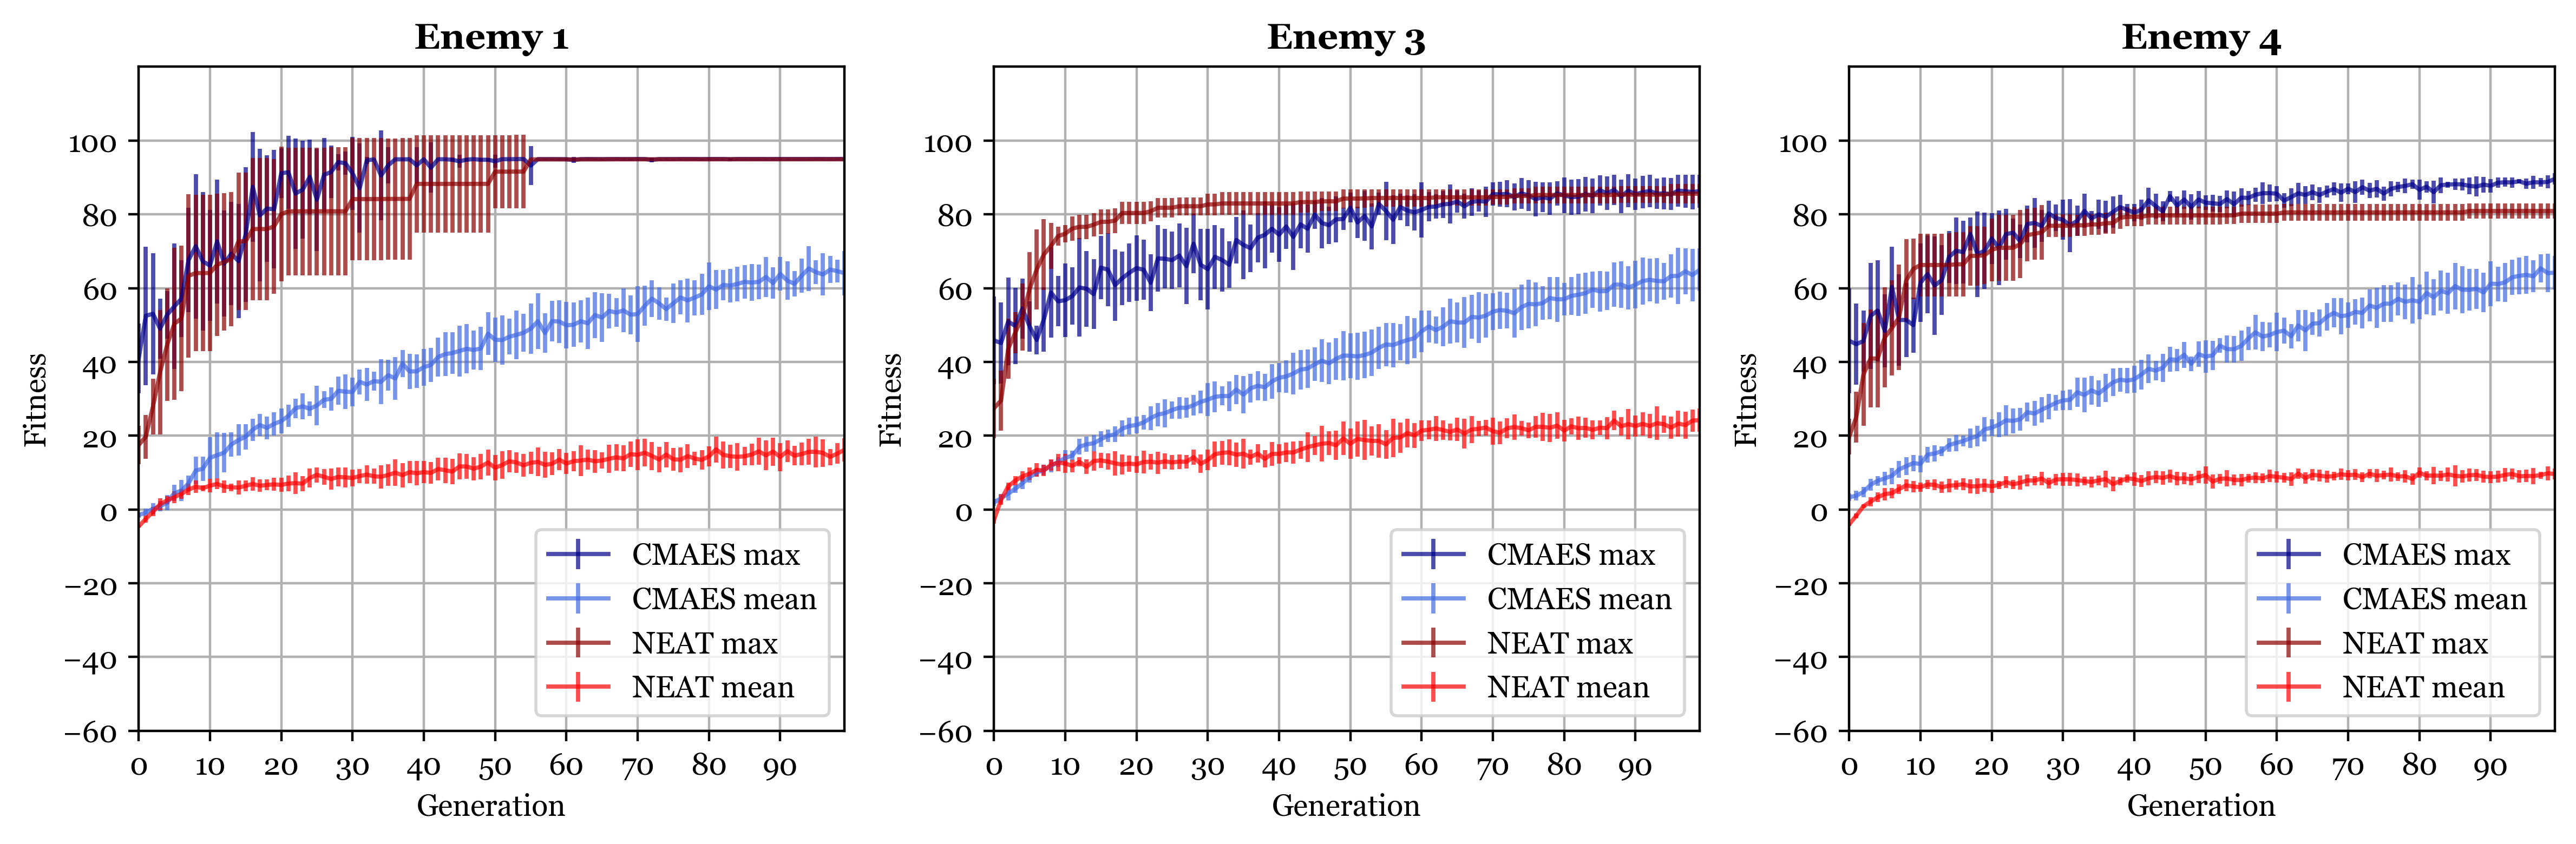

In [125]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4), dpi=400)
xx = np.arange(0, n_gens, 1, dtype=int)

def plot_mean_with_sd(ax, xx, means, sds, color="blue", fill_color="lightblue", linestyle="solid", label=""):
    ax.plot(means, color=color, linestyle=linestyle, lw=2.5, label=label)
    ax.plot(means + sds, color=color, linestyle=linestyle, lw=1.25)
    ax.plot(means - sds, color=color, linestyle=linestyle, lw=1.25)
    ax.fill_between(xx, means + sds, means - sds, color=fill_color)

# Plot setup
for (i, enemy) in enumerate(ENEMIES):
    # Y-axis
    axes[i].set_ylim(-60, 120)
    axes[i].set_yticks(np.arange(-60, 120, 20))
    axes[i].set_ylabel("Fitness")

    # X-axis
    axes[i].set_xlim(0, n_gens - 1)
    axes[i].set_xticks(np.arange(0, n_gens, 10))
    axes[i].set_xlabel("Generation")

    # Whole plot
    axes[i].set_title(f"Enemy {enemy}", weight="bold")
    axes[i].grid()

# Plotting data
for i in range(len(ENEMIES)):
    axes[i].errorbar(range(n_gens), cmaes_avg_max[i], yerr=cmaes_sd_max[i], alpha=0.7, lw=1.4, color="darkblue", label="CMAES max")
    axes[i].errorbar(range(n_gens), cmaes_avg_mean[i], yerr=cmaes_sd_mean[i], alpha=0.7, lw=1.4, color="royalblue", label="CMAES mean")

    axes[i].errorbar(range(n_gens), neat_avg_max[i], yerr=neat_sd_max[i], alpha=0.7, lw=1.4, color="darkred", label="NEAT max")
    axes[i].errorbar(range(n_gens), neat_avg_mean[i], yerr=neat_sd_mean[i], alpha=0.7, lw=1.4, color="red", label="NEAT mean")

    axes[i].legend(loc="lower right")

fig.tight_layout()
plt.show()

### Fitness plot: variant with Hall-of-Fame in CMAES

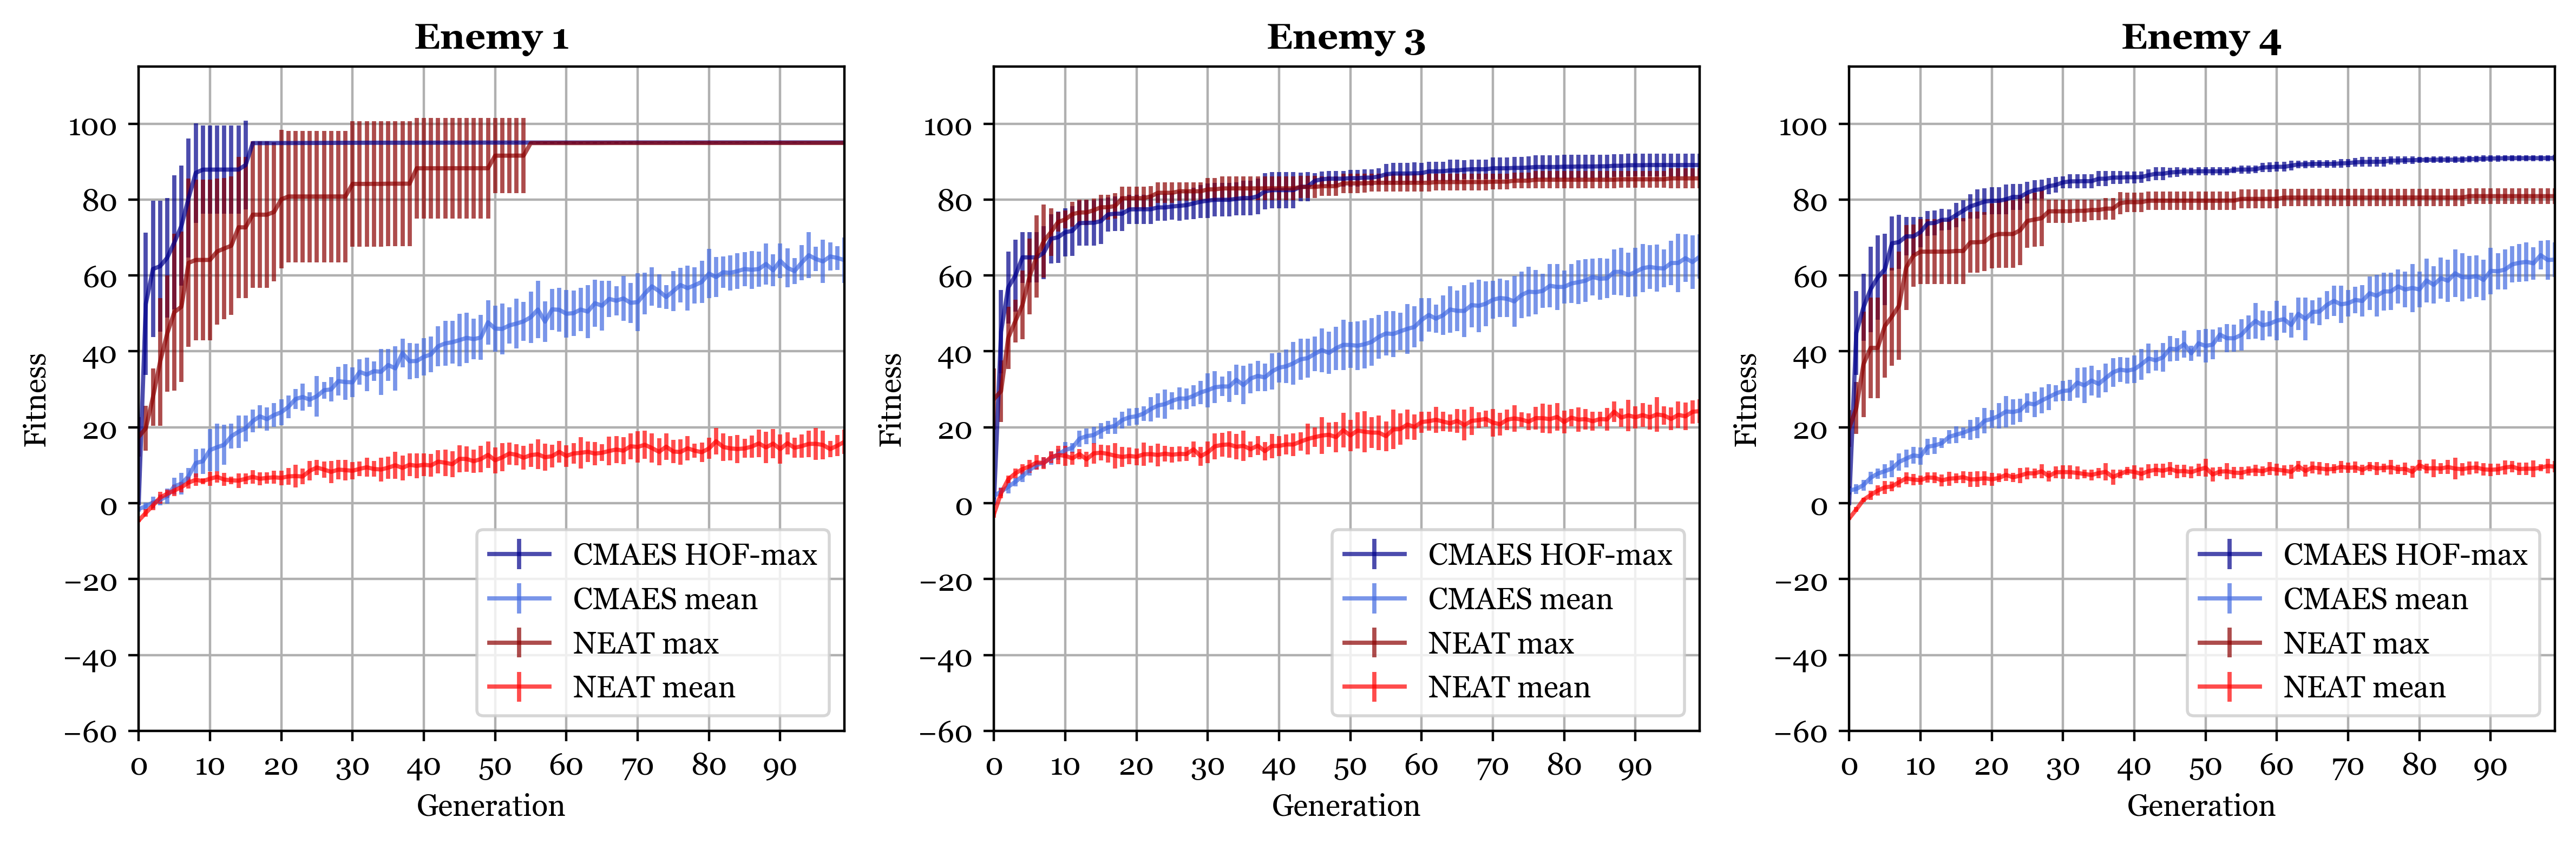

In [126]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4), dpi=400)
xx = np.arange(0, n_gens, 1, dtype=int)

def plot_mean_with_sd(ax, xx, means, sds, color="blue", fill_color="lightblue", linestyle="solid", label=""):
    ax.plot(means, color=color, linestyle=linestyle, lw=2.5, label=label)
    ax.plot(means + sds, color=color, linestyle=linestyle, lw=1.25)
    ax.plot(means - sds, color=color, linestyle=linestyle, lw=1.25)
    ax.fill_between(xx, means + sds, means - sds, color=fill_color)

# Plot setup
for (i, enemy) in enumerate(ENEMIES):
    # Y-axis
    axes[i].set_ylim(-60, 115)
    axes[i].set_yticks(np.arange(-60, 101, 20))
    axes[i].set_ylabel("Fitness")

    # X-axis
    axes[i].set_xlim(0, n_gens - 1)
    axes[i].set_xticks(np.arange(0, n_gens, 10))
    axes[i].set_xlabel("Generation")

    # Whole plot
    axes[i].set_title(f"Enemy {enemy}", weight="bold")
    axes[i].grid()

# Plotting data
for i in range(len(ENEMIES)):
    axes[i].errorbar(range(n_gens), cmaes_avg_hof[i], yerr=cmaes_sd_hof[i], alpha=0.7, lw=1.4, color="darkblue", label="CMAES HOF-max")
    axes[i].errorbar(range(n_gens), cmaes_avg_mean[i], yerr=cmaes_sd_mean[i], alpha=0.7, lw=1.4, color="royalblue", label="CMAES mean")

    axes[i].errorbar(range(n_gens), neat_avg_max[i], yerr=neat_sd_max[i], alpha=0.7, lw=1.4, color="darkred", label="NEAT max")
    axes[i].errorbar(range(n_gens), neat_avg_mean[i], yerr=neat_sd_mean[i], alpha=0.7, lw=1.4, color="red", label="NEAT mean")

    axes[i].legend(loc="lower right")

fig.tight_layout()
plt.show()

Fitness plot both max and HOF

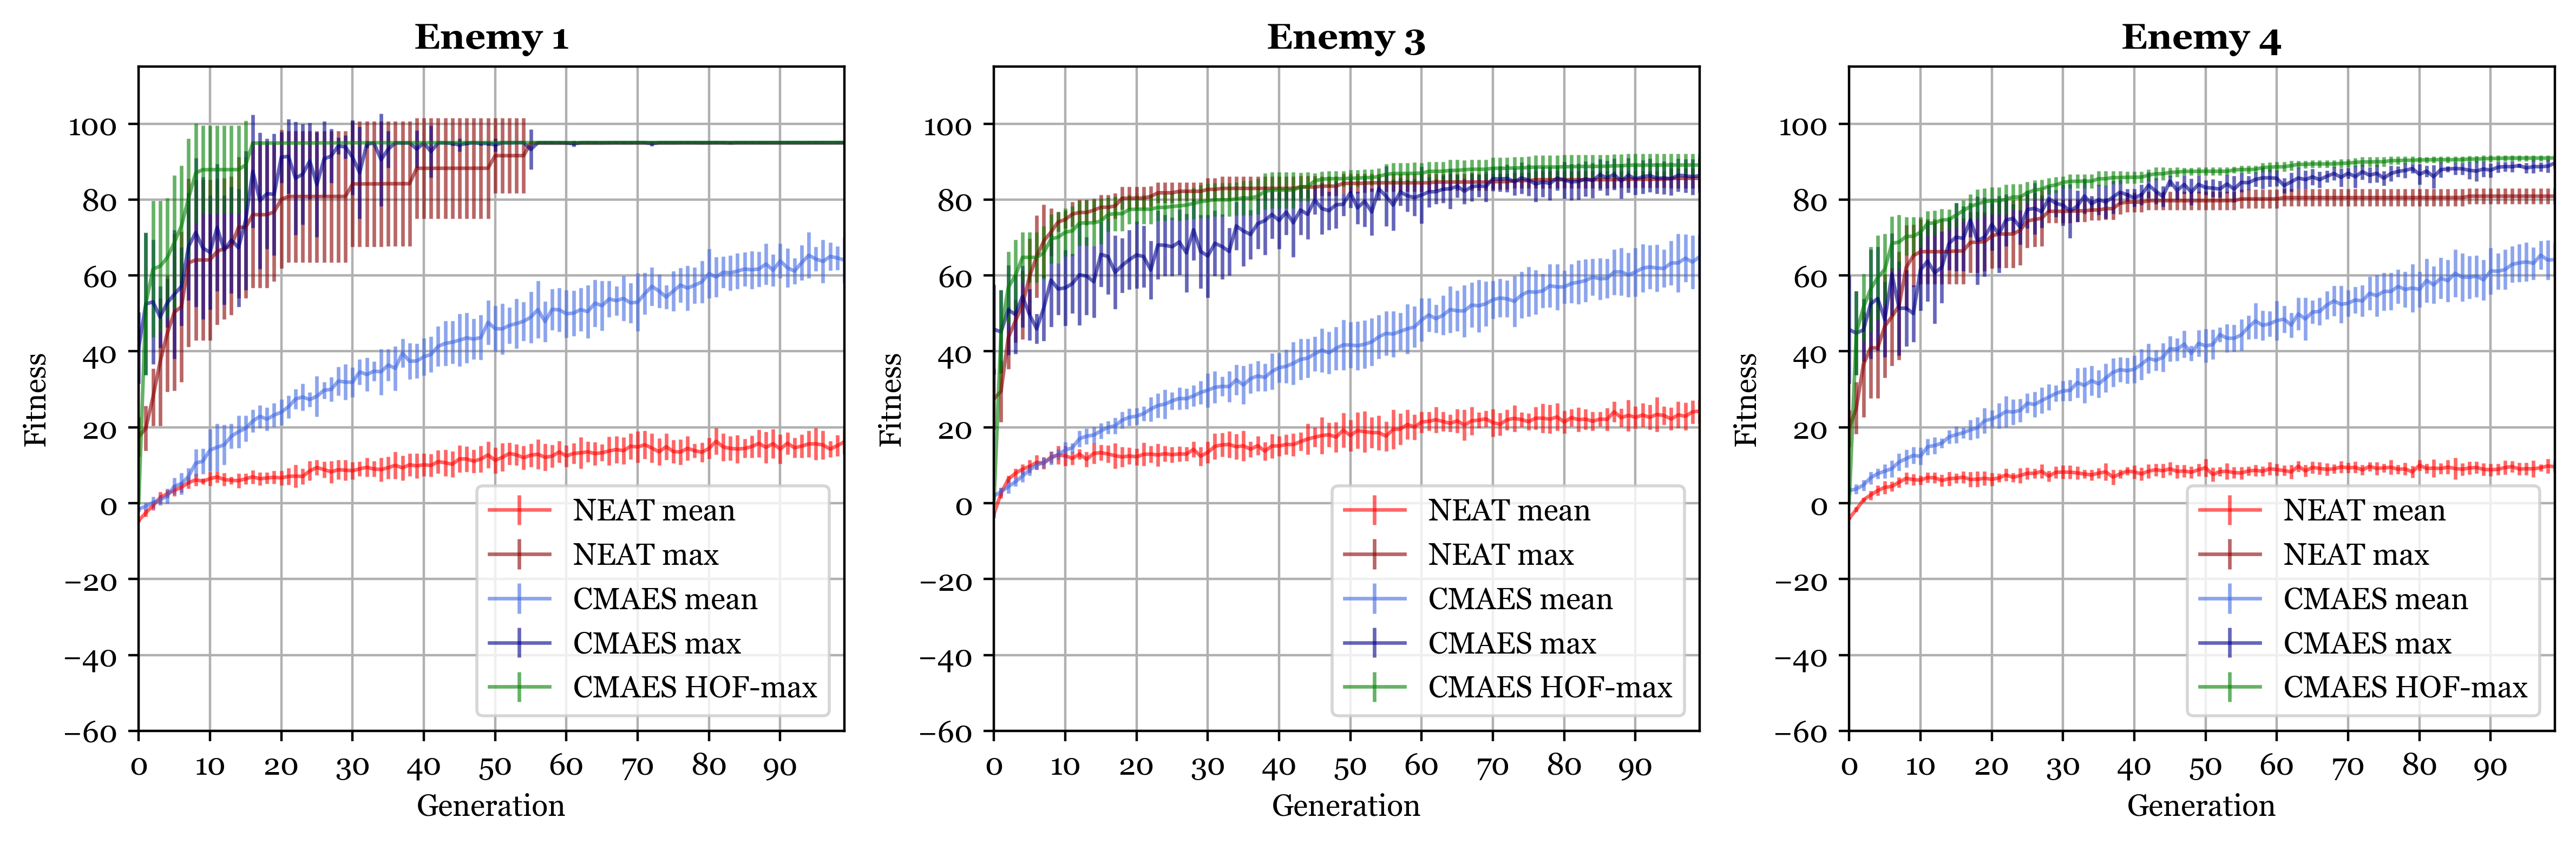

In [146]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4), dpi=400)
xx = np.arange(0, n_gens, 1, dtype=int)

def plot_mean_with_sd(ax, xx, means, sds, color="blue", fill_color="lightblue", linestyle="solid", label=""):
    ax.plot(means, color=color, linestyle=linestyle, lw=2.5, label=label)
    ax.plot(means + sds, color=color, linestyle=linestyle, lw=1.25)
    ax.plot(means - sds, color=color, linestyle=linestyle, lw=1.25)
    ax.fill_between(xx, means + sds, means - sds, color=fill_color)

# Plot setup
for (i, enemy) in enumerate(ENEMIES):
    # Y-axis
    axes[i].set_ylim(-60, 115)
    axes[i].set_yticks(np.arange(-60, 101, 20))
    axes[i].set_ylabel("Fitness")

    # X-axis
    axes[i].set_xlim(0, n_gens - 1)
    axes[i].set_xticks(np.arange(0, n_gens, 10))
    axes[i].set_xlabel("Generation")

    # Whole plot
    axes[i].set_title(f"Enemy {enemy}", weight="bold")
    axes[i].grid()

# Plotting data
for i in range(len(ENEMIES)):
    axes[i].errorbar(range(n_gens), neat_avg_mean[i], yerr=neat_sd_mean[i], alpha=0.6, lw=1.2, color="red", label="NEAT mean")
    axes[i].errorbar(range(n_gens), neat_avg_max[i], yerr=neat_sd_max[i], alpha=0.6, lw=1.2, color="darkred", label="NEAT max")
    axes[i].errorbar(range(n_gens), cmaes_avg_mean[i], yerr=cmaes_sd_mean[i], alpha=0.6, lw=1.2, color="royalblue", label="CMAES mean")
    axes[i].errorbar(range(n_gens), cmaes_avg_max[i], yerr=cmaes_sd_max[i], alpha=0.6, lw=1.2, color="darkblue", label="CMAES max")
    axes[i].errorbar(range(n_gens), cmaes_avg_hof[i], yerr=cmaes_sd_hof[i], alpha=0.6, lw=1.2, color="green", label="CMAES HOF-max")

    axes[i].legend(loc="lower right")

fig.tight_layout()
plt.show()

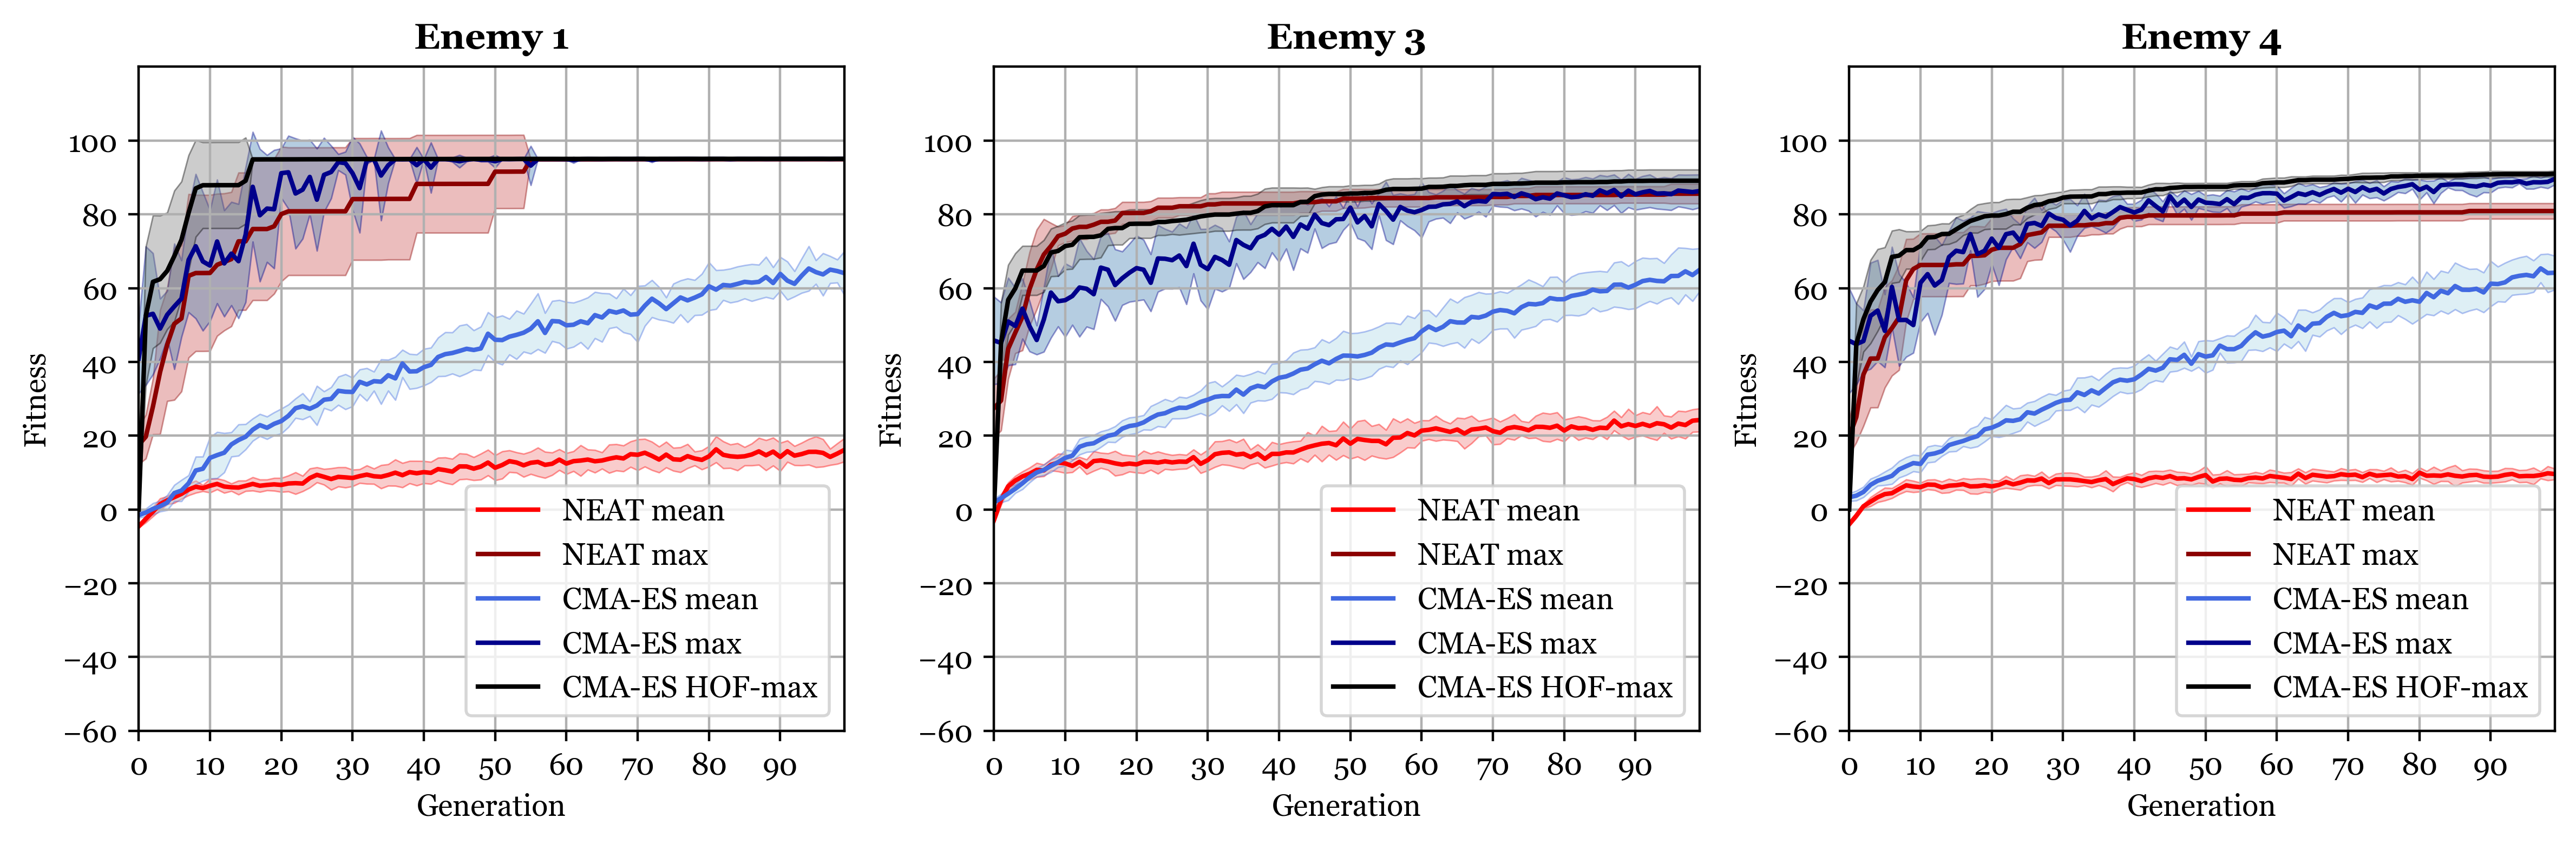

In [143]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4), dpi=400)
xx = np.arange(0, n_gens, 1, dtype=int)

def plot_mean_with_sd(ax, xx, means, sds, color="blue", fill_color="lightblue", linestyle="solid", label=""):
    ax.plot(xx, means, color=color, linestyle=linestyle, lw=1.5, label=label)
    ax.fill_between(xx, means + sds, means - sds, color=fill_color, alpha=0.4, edgecolor=color, linewidth=0.5)

# Plot setup
for (i, enemy) in enumerate(ENEMIES):
    # Y-axis
    axes[i].set_ylim(-50, 120)
    axes[i].set_yticks(np.arange(-60, 120, 20))
    axes[i].set_ylabel("Fitness")

    # X-axis
    axes[i].set_xlim(0, n_gens - 1)
    axes[i].set_xticks(np.arange(0, n_gens, 10))
    axes[i].set_xlabel("Generation")

    # Whole plot
    axes[i].set_title(f"Enemy {enemy}", weight="bold")
    axes[i].grid()

# Plotting data
for i in range(len(ENEMIES)):
    plot_mean_with_sd(axes[i], xx, neat_avg_mean[i], neat_sd_mean[i], color="red", fill_color="lightcoral", label="NEAT mean")
    plot_mean_with_sd(axes[i], xx, neat_avg_max[i], neat_sd_max[i], color="darkred", fill_color="indianred", label="NEAT max")
    plot_mean_with_sd(axes[i], xx, cmaes_avg_mean[i], cmaes_sd_mean[i], color="royalblue", fill_color="lightblue", label="CMA-ES mean")
    plot_mean_with_sd(axes[i], xx, cmaes_avg_max[i], cmaes_sd_max[i], color="darkblue", fill_color="steelblue", label="CMA-ES max")
    # plot_mean_with_sd(axes[i], xx, cmaes_avg_hof[i], cmaes_sd_hof[i], color="midnightblue", fill_color="cadetblue", label="CMAES HOF-max")
    plot_mean_with_sd(axes[i], xx, cmaes_avg_hof[i], cmaes_sd_hof[i], color="black", fill_color="grey", label="CMA-ES HOF-max")
    axes[i].legend(loc="lower right")

fig.tight_layout()
plt.show()

### Optional: all runs (CMAES HOF-MAX)

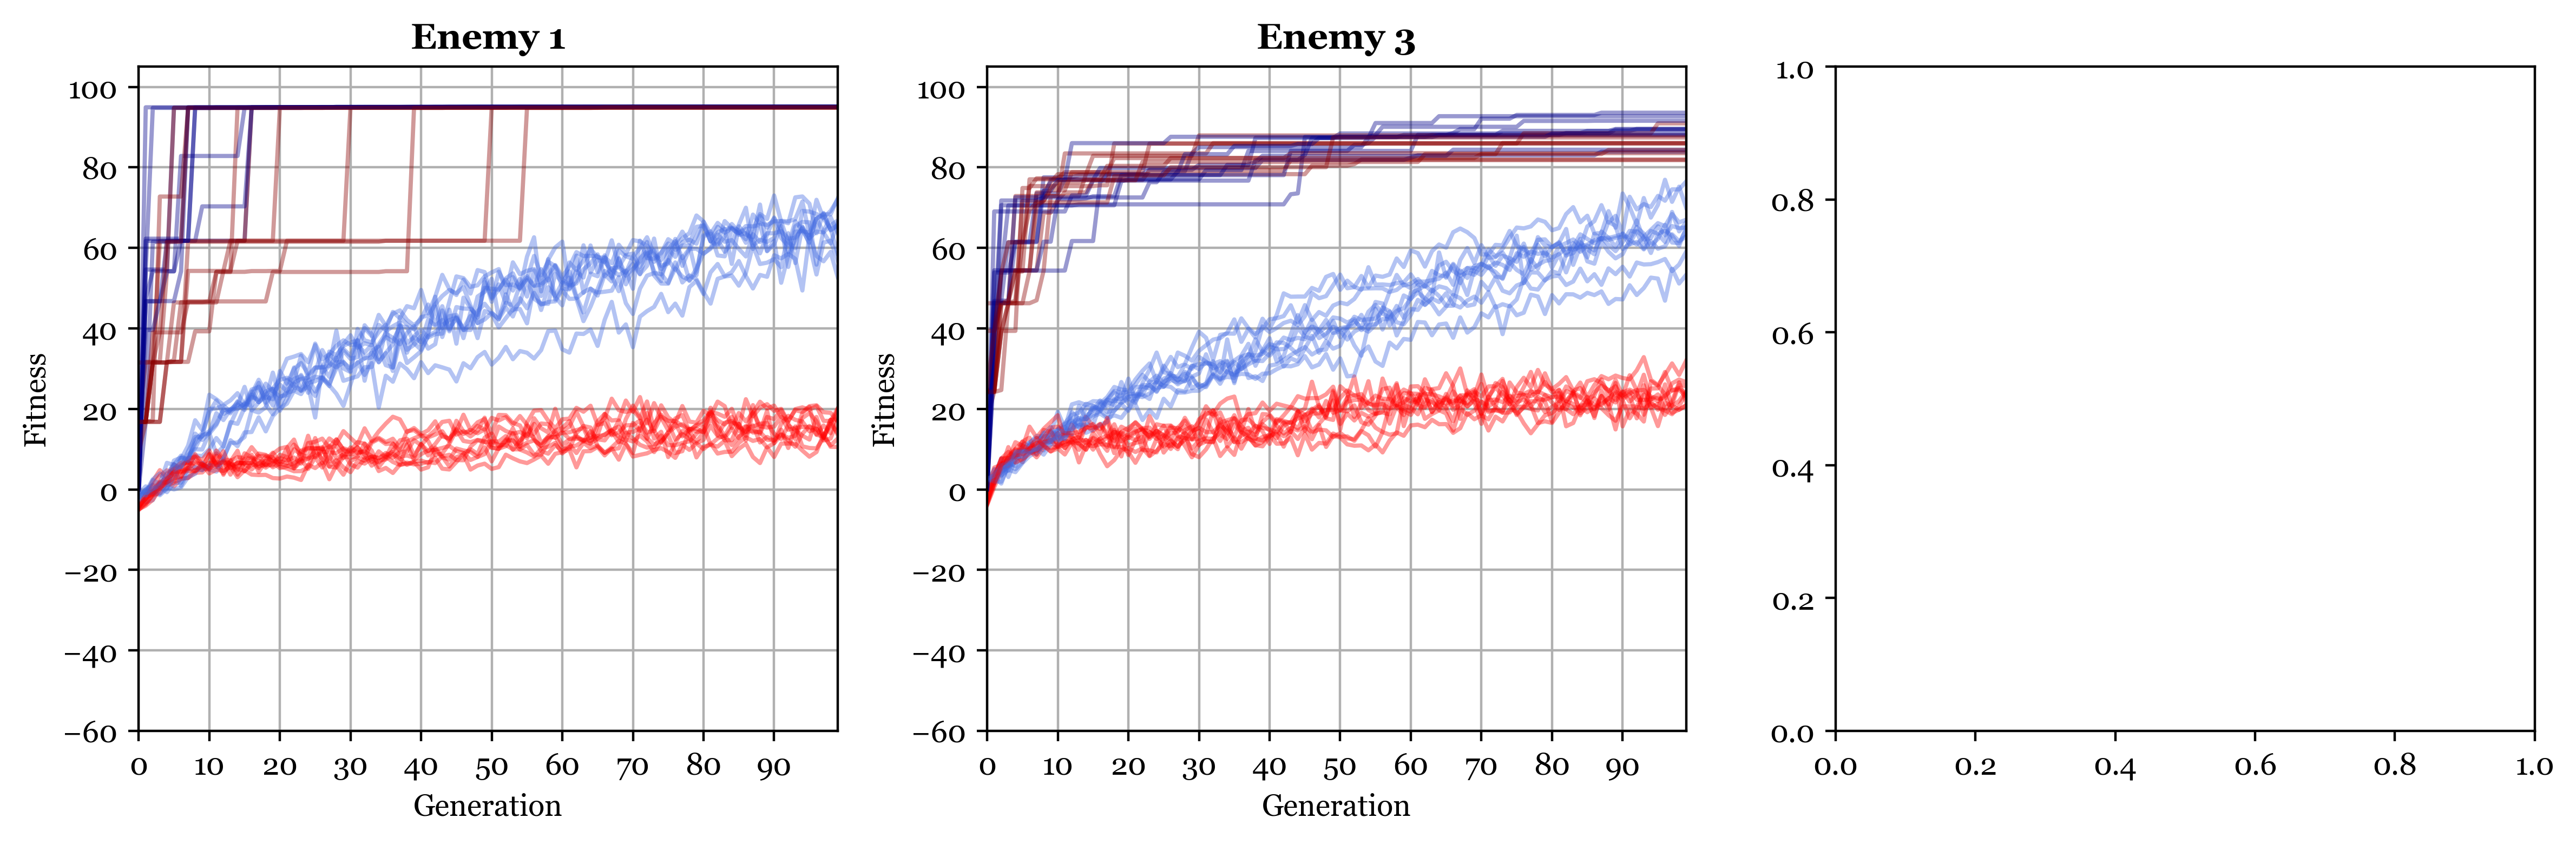

In [103]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4), dpi=400)
xx = np.arange(0, n_gens, 1, dtype=int)

def plot_mean_with_sd(ax, xx, means, sds, color="blue", fill_color="lightblue", linestyle="solid", label=""):
    ax.plot(means, color=color, linestyle=linestyle, lw=2.5, label=label)
    ax.plot(means + sds, color=color, linestyle=linestyle, lw=1.25)
    ax.plot(means - sds, color=color, linestyle=linestyle, lw=1.25)
    ax.fill_between(xx, means + sds, means - sds, color=fill_color)

# Plot setup
for (i, enemy) in enumerate(ENEMIES):
    # Y-axis
    axes[i].set_ylim(-60, 105)
    axes[i].set_yticks(np.arange(-60, 101, 20))
    axes[i].set_ylabel("Fitness")

    # X-axis
    axes[i].set_xlim(0, n_gens - 1)
    axes[i].set_xticks(np.arange(0, n_gens, 10))
    axes[i].set_xlabel("Generation")

    # Whole plot
    axes[i].set_title(f"Enemy {enemy}", weight="bold")
    axes[i].grid()

# Plotting data
for i in range(len(ENEMIES)):
    for j in range(n_runs):
        axes[i].plot(range(n_gens), cmaes_hof[i, j], alpha=0.4, lw=1.4, color='darkblue')
        axes[i].plot(range(n_gens), cmaes_mean[i, j], alpha=0.4, lw=1.4, color='royalblue')

        axes[i].plot(range(n_gens), neat_max[i, j], alpha=0.4, lw=1.4, color='darkred')
        axes[i].plot(range(n_gens), neat_mean[i, j], alpha=0.4, lw=1.4, color='red')

fig.tight_layout()
plt.show()

## Part 2: Boxplot

I'll do 50 runs instead of 5. Seems like it makes more sense.

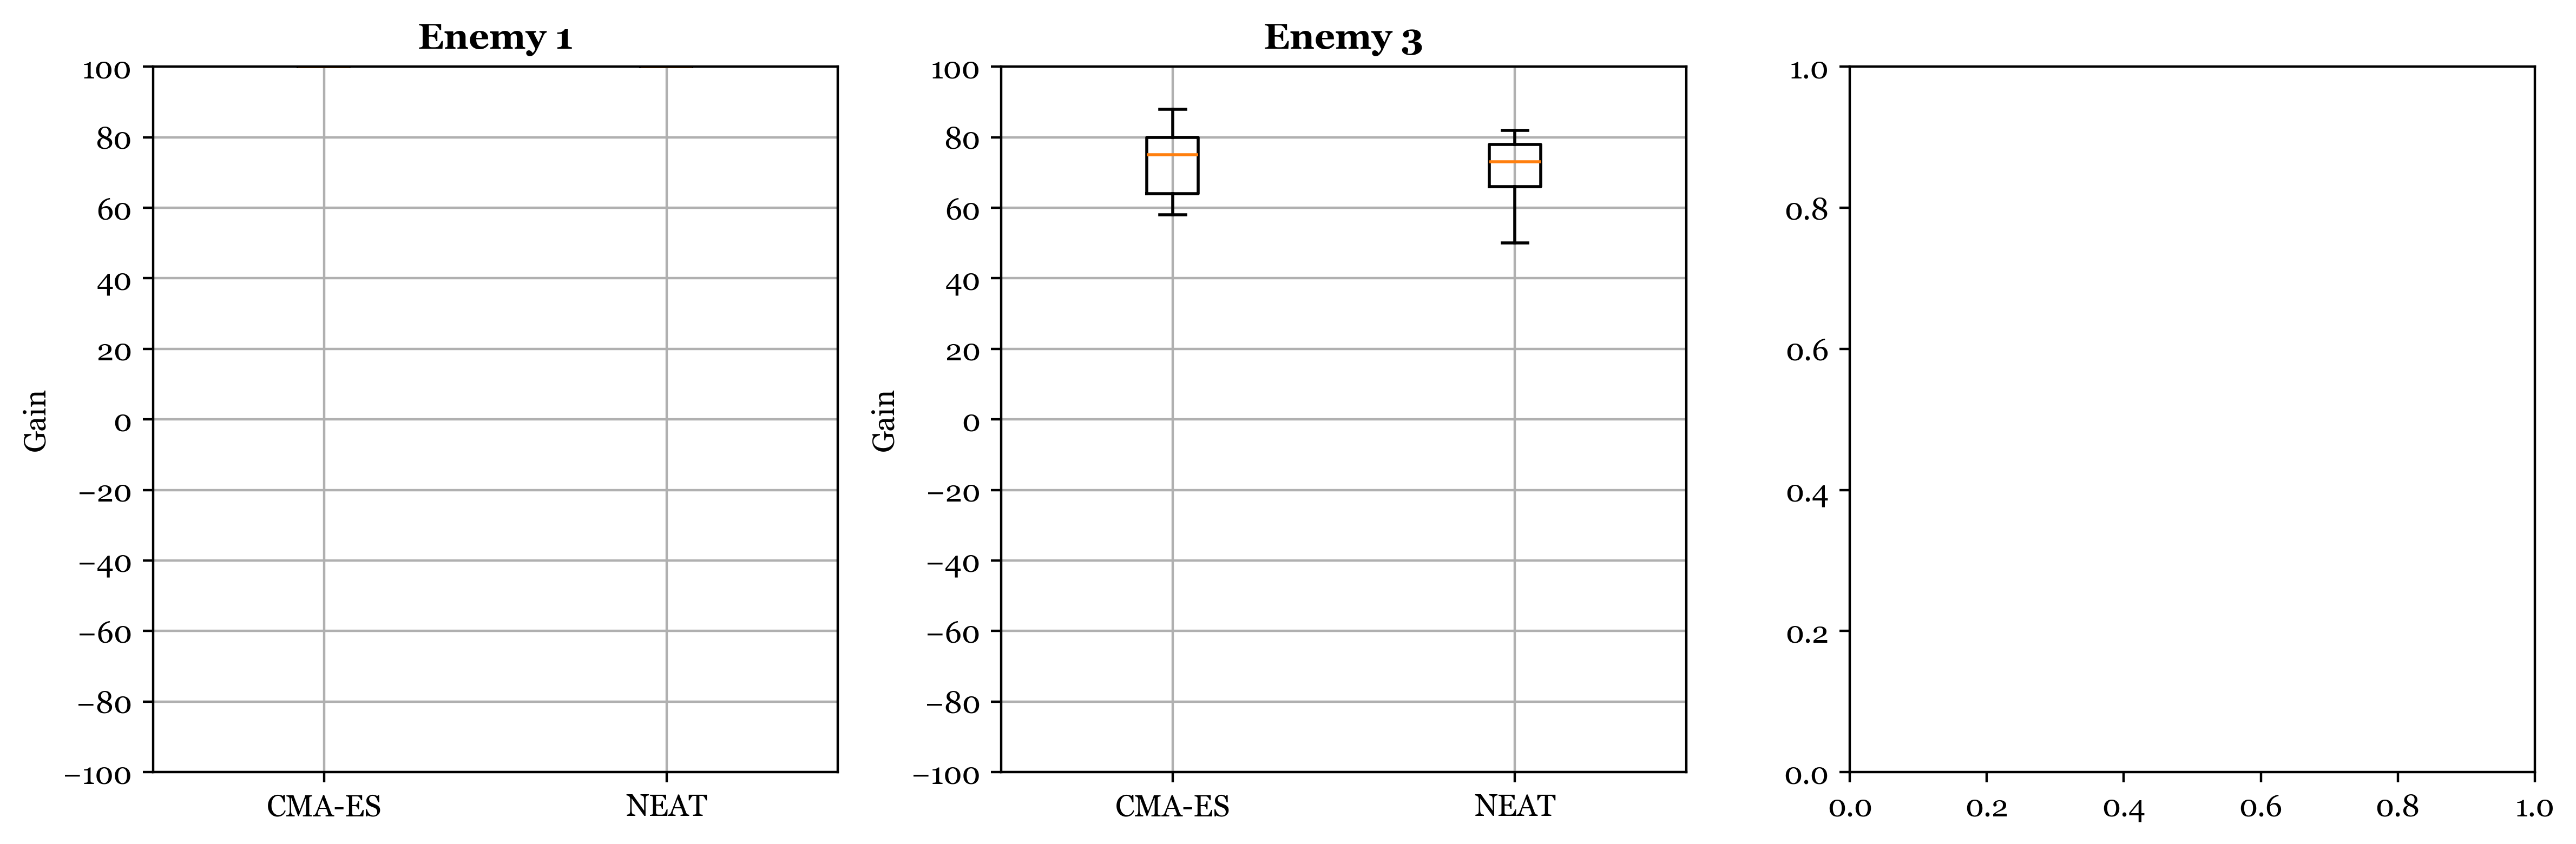

In [104]:
from scipy.stats import ttest_ind

fig, axes = plt.subplots(1, 3, figsize=(12, 4), dpi=400)

def plot_mean_with_sd(ax, xx, means, sds, color="blue", fill_color="lightblue", linestyle="solid", label=""):
    ax.plot(means, color=color, linestyle=linestyle, lw=2.5, label=label)
    ax.plot(means + sds, color=color, linestyle=linestyle, lw=1.25)
    ax.plot(means - sds, color=color, linestyle=linestyle, lw=1.25)
    ax.fill_between(xx, means + sds, means - sds, color=fill_color)

# Plot setup
for (i, enemy) in enumerate(ENEMIES):
    # Y-axis
    axes[i].set_ylim(-100, 100)
    axes[i].set_yticks(np.arange(-100, 101, 20))
    axes[i].set_ylabel("Gain")

    # Whole plot
    axes[i].set_title(f"Enemy {enemy}", weight="bold")
    axes[i].grid()

# Plotting data
for i in range(len(ENEMIES)):
    axes[i].boxplot([cmaes_gains[i], neat_gains[i]])
    axes[i].set_xticklabels(['CMA-ES', 'NEAT'])

fig.tight_layout()
plt.show()

In [105]:
for i in range(len(ENEMIES)):
    print(ttest_ind(cmaes_gains[i], neat_gains[i]).pvalue)

nan
0.22111366660376866


/opt/homebrew/Caskroom/miniconda/base/envs/evoman/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:573: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


### Decisions and Strategies

In [ ]:
cmaes_decisions.shape

In [ ]:
from scipy.stats import ttest_ind

mpl.rc('font', size=10)

ALGORITHMS = ['CMA-ES', 'NEAT']
MOVES = ['left', 'right', 'jump', 'shoot', 'release', 'move', 'jump or release']
COLORS = ['black', 'blue', 'red', 'green']

fig, axes = plt.subplots(2, len(ENEMIES), figsize=(12, 5))

# Plot setup
for (k, alg) in enumerate(ALGORITHMS):
    for (i, enemy) in enumerate(ENEMIES):
        # Y-axis
        axes[k, i].set_ylim(0, 1.0)
        axes[k, i].set_yticks(np.arange(0, 1.01, 0.2))
        axes[k, i].set_ylabel("Mean % active per game")

        # Y-axis
        axes[k, i].set_xlim(0, n_gens)
        axes[k, i].set_xticks(np.arange(0, n_gens + 1, 20))
        axes[k, i].set_xlabel("Generation")

        # Whole plot
        axes[k, i].set_title(f"Enemy {enemy} ({alg})", weight="bold")
        axes[k, i].grid()

# Plotting data
for (k, alg) in enumerate(ALGORITHMS):
    # TODO: Remove '[:1]'
    for i in range(len(ENEMIES)):
        for (j, move) in enumerate(MOVES[2:6], 2):
            if k == 0:
                axes[k, i].plot(cmaes_decisions[i, :, 0, j], alpha=0.7, lw=2.0, marker='.', ms=0.8, color=COLORS[j-2], label=move)
            else:
                axes[k, i].plot(neat_decisions[i, :, 0, j], alpha=0.7, lw=0.8, marker='.', ms=0.8, color="blue")
        
fig.tight_layout(rect=[0, 0, 1, 0.95])
fig.legend(labels=['jump', 'shoot', 'release', 'move'], loc='upper center', ncol=4, bbox_to_anchor=(0.5, 1.02), fontsize=14, frameon=False)
plt.show()